<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/gpu_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to GPU programming with Numba

This notebook borrows *heavily* from [seibert's 2018 gtc numba tutorial](https://github.com/ContinuumIO/gtc2018-numba). I highly recommend that tutorial in its entireity if you want more practice with Numba and GPUs.

Yesterday we discussed the principles of parallel programming, and explored the key aspects of using Numba - the `@jit` decorator, benchmarking, and the `@vectorize` decorator for Numpy UFuncs. Today we are going to expand on that basis and use Numba to do parallel calculations in python by taking advantage of Numba's GPU interface (and Google's free GPUs - thanks Colaboratory!).

In [0]:
import numpy as np
import math
from numba import vectorize, cuda
from matplotlib import pyplot as plt
%matplotlib inline

#### Problem 0 - Accessing the GPU

**0a)** In order to run Numba functions using the GPU, we have to do a couple of things. First, go to the Runtime menu, click on 'Change Runtime Type', and in the pop-up box, under 'Hardware Accelerator', select 'GPU'. Save the Runtime.

**0b)** Ideally, that's all we should have to do. But in practice, even though the Cuda libararies are installed, for some reason Colab usually can't find them. So, we'll just figure out where they are, and then point Colab to them.

In [2]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so


Paste the location of the libraries into the following code box (if it's different, otherwise you can just run the code):

In [0]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

And that should do it! Okay, now that we've pointed Numba to the correct libraries, let's get going. To start, we are going to return to the simplest function we created yesterday - the vector add.

### Problem 1 - Vector Addition on GPUs

The simplest way to access the GPU through Numba is to return to our vectorized ufunc from yesterday. As you may recall, Numpy Universal Functions operate on vectors, or arrays. If we specify the `cuda` target, Numba will automatically write a Cuda kernel for us, and run the function on the GPU! Let's try it out:

In [0]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [0]:
a = np.arange(n)
b = 2 * a

In [22]:
add_ufunc(a,b)

array([     0,      3,      6, ..., 299991, 299994, 299997])

Cool, it worked! But what actually just happened? Well, a lot of things. Numba automatically:
+ Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
+ Allocated GPU memory for the inputs and the output.
+ Copied the input data to the GPU.
+ Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
+ Copied the result back from the GPU to the CPU.
+ Returned the result as a NumPy array on the host.

**1a)** Determine how fast the cuda addition function is. Compare that to a function compiled for the CPU. How does the GPU do?

In [23]:
%timeit add_ufunc(a,b) # add code here

100 loops, best of 3: 2.59 ms per loop


**1b)** Wow, the GPU is a LOT slower! Why might that be?

Answer: We have (deliberately) misused the GPU in several ways in this example:
+ **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once. Our test inputs have only 10 integers. We need a much larger array to even keep the GPU busy.
+ **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU. If our calculation does not involve enough math operations ("arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
+ **We copy the data to and from the GPU**: While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence. In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
+ **Our data types are larger than necessary**: Our example uses int64 when we probably don't need it. Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU. Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats. NumPy defaults to 64-bit data types when creating arrays, so it is important to set the dtype attribute or use the ndarray.astype() method to pick 32-bit types when you need them.


####Problem 2 - Memory Management

As we saw in the last problem, Numba can automatically handle transferring data to and from the GPU for us. However, that's not always what we want. Sometimes we will want to perform several functions in a row on the GPU without transferring the data back to the CPU in between.

**2a)** Remake the addition ufunc to operate on and return 32 bit floats

In [0]:
@vectorize(['float32(float32, float32)'], target='cuda') # add code here
def add_ufunc(x, y):
    return x + y

Now, let's give it a bit more work to do:

In [0]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

As we saw in the last problem, copying the data to and from the GPU for every function is not necessarily the most efficient way to use the GPU. To address this, Numba provides function in the cuda module to allocate and copy arrays to the GPU:

In [27]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


`x_device` and `y_device` are now Numba "device arrays" that are in many ways equivalent to Numpy ndarrays except that they live in the GPU's global memory, rather than on the CPU. These device arrays can be passed to Numba cuda functions just the way Numpy arrays can, but without the memory copying overhead.

**2b)** Try out your function using host vs device arrays. How does the time compare?

In [29]:
%timeit add_ufunc(x, y)

1000 loops, best of 3: 1.81 ms per loop


In [30]:
%timeit add_ufunc(x_device, y_device)

1000 loops, best of 3: 1.02 ms per loop


That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host. We can create the output buffer with the numba.cuda.device_array() function:

In [0]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, much like np.empty()

And then we can use a special out keyword argument to the ufunc to specify the output buffer:

In [32]:
%timeit add_ufunc(x_device, y_device, out=out_device)

The slowest run took 7.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 747 µs per loop


Now we're cooking with gas! Once we've finished all of our calculations on the GPU, we can copy the array back from the device using the `copy_to_host` method:

In [33]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


**2c)** Given these ufuncs:

In [0]:
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

Convert the following code to use device allocations so that there are only host<->device copies at the beginning and end. Then benchmark the performance change.

In [0]:
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

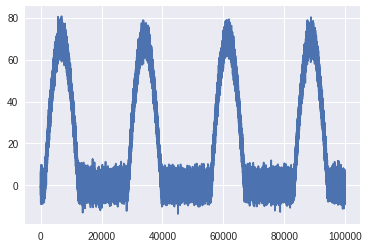

In [40]:
plt.plot(waveform)